In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import csv
import pandas as pd

In [2]:
net = cv.dnn.readNetFromTensorflow("graph_opt.pb") # weights

In [3]:
inWidth = 368
inHeight = 368
thr = 0.2

In [4]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [5]:
img = cv.imread("image.JPG")

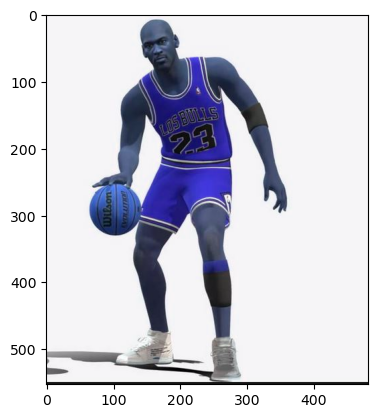

In [6]:
plt.imshow(img) #BGR

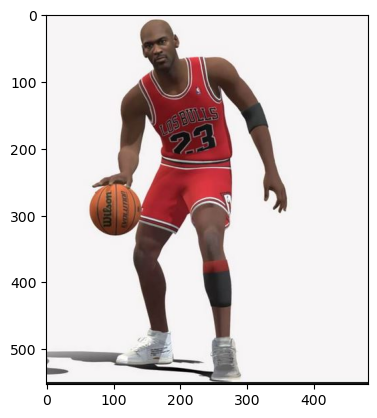

In [7]:
plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))

# Pose Estimation on Image

In [8]:
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame,1.0,(inWidth,inHeight), (127.5,127.5,127.5),swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = [] 
    
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    return frame, points

In [9]:
estimated_image, points = pose_estimation(img)

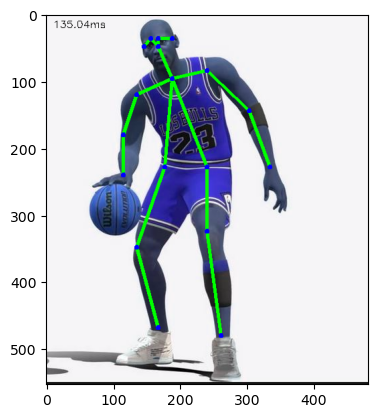

In [10]:
plt.imshow(estimated_image)

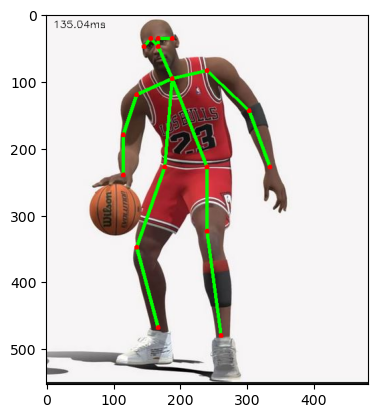

In [11]:
plt.imshow(cv.cvtColor(estimated_image,cv.COLOR_BGR2RGB))

In [12]:
# Access the coordinates of each body part
for part_name, x in BODY_PARTS.items():
    part_id = BODY_PARTS[part_name]
    coordinates = points[part_id] if points[part_id] is not None else "Not detected"
    print(f"{part_name}: {coordinates}")

Nose: (167, 48)
Neck: (188, 96)
RShoulder: (135, 120)
RElbow: (115, 180)
RWrist: (115, 240)
LShoulder: (240, 84)
LElbow: (303, 144)
LWrist: (334, 228)
RHip: (177, 228)
RKnee: (135, 348)
RAnkle: (167, 468)
LHip: (240, 228)
LKnee: (240, 324)
LAnkle: (261, 480)
REye: (156, 36)
LEye: (167, 36)
REar: (146, 48)
LEar: (188, 36)
Background: (460, 12)


# Pose Estimation on Video

In [13]:
cap = cv.VideoCapture('video.mp4')
cap.set(3,800)
cap.set(4,800)

if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open video")
    
frame_points = []
    
while cv.waitKey(1) < 0:
    hasFrame, frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break
        
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame,1.0,(inWidth,inHeight), (127.5,127.5,127.5),swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = [] 
    
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)
    
    frame_points.append(points)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    
    cv.imshow('PoseEstTutotial', frame)
    
# Save the coordinates of body parts with frame number and body part name
with open('body_parts_coordinates.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Frame', 'Body Part', 'Coordinates'])
    for frame_num, points in enumerate(frame_points):
        for part_name, x in BODY_PARTS.items():
            part_id = BODY_PARTS[part_name]
            coordinates = points[part_id] if points[part_id] is not None else 'Not detected'
            writer.writerow([frame_num, part_name, coordinates])

# Release the video capture and close the OpenCV windows
cap.release()
cv.destroyAllWindows()

In [14]:
df = pd.read_csv('body_parts_coordinates.csv')
df

Frame   Body Part   Coordinates
0         0        Nose    (667, 156)
1         0        Neck    (612, 203)
2         0   RShoulder    (584, 203)
3         0      RElbow    (528, 281)
4         0      RWrist    (556, 328)
...     ...         ...           ...
2446    128        REye  Not detected
2447    128        LEye    (640, 140)
2448    128        REar  Not detected
2449    128        LEar    (667, 140)
2450    128  Background   (1252, 438)

[2451 rows x 3 columns]

In [15]:
bodyPartCoordinates = df.pivot(index='Frame', columns='Body Part', values='Coordinates')
bodyPartCoordinates

Body Part   Background      LAnkle          LEar        LElbow          LEye  \
Frame                                                                          
0           (1224, 15)  (584, 516)  Not detected    (695, 266)    (667, 140)   
1           (1224, 15)  (556, 500)  Not detected    (667, 266)    (667, 140)   
2           (1224, 15)  (640, 532)  Not detected    (667, 250)    (667, 140)   
3           (1224, 15)  (640, 532)  Not detected    (667, 266)    (667, 140)   
4           (1224, 15)  (612, 547)  Not detected    (695, 281)    (667, 140)   
...                ...         ...           ...           ...           ...   
124        (1252, 532)  (667, 438)    (695, 140)  Not detected    (667, 140)   
125        (1252, 532)  (667, 579)    (695, 140)    (612, 219)    (667, 140)   
126           (556, 0)  (667, 579)    (695, 187)    (584, 234)  Not detected   
127        (1252, 438)  (640, 422)    (667, 140)    (584, 234)    (640, 140)   
128        (1252, 438)  (723, 563)    (667, 140)    (612, 234)    (640, 140)   

Body Part        LHip         LKnee   LShoulder        LWrist        Neck  \
Frame                                                                       
0          (612, 328)    (640, 422)  (667, 203)    (723, 328)  (612, 203)   
1          (584, 328)    (612, 438)  (667, 203)    (723, 328)  (612, 203)   
2          (584, 313)    (584, 469)  (640, 203)    (723, 313)  (612, 203)   
3          (584, 313)    (584, 469)  (640, 203)    (723, 297)  (584, 203)   
4          (584, 313)    (584, 453)  (640, 203)    (695, 297)  (584, 203)   
...               ...           ...         ...           ...         ...   
124        (667, 328)  Not detected  (667, 203)  Not detected  (695, 219)   
125        (667, 344)    (640, 406)  (695, 203)    (640, 187)  (667, 203)   
126        (640, 344)    (640, 469)  (667, 219)    (612, 187)  (695, 219)   
127        (640, 313)    (640, 360)  (667, 219)    (640, 187)  (667, 219)   
128        (667, 297)    (640, 500)  (695, 219)    (640, 203)  (667, 203)   

Body Part          Nose      RAnkle          REar        RElbow          REye  \
Frame                                                                           
0            (667, 156)  (584, 516)    (612, 156)    (528, 281)    (667, 140)   
1            (667, 156)  (612, 532)    (612, 140)    (528, 266)    (640, 140)   
2            (640, 156)  (640, 532)    (612, 140)    (528, 250)    (640, 140)   
3            (640, 140)  (528, 375)    (612, 140)    (500, 250)    (640, 140)   
4            (640, 156)  (612, 547)    (612, 140)    (500, 266)    (640, 140)   
...                 ...         ...           ...           ...           ...   
124          (667, 140)  (667, 422)  Not detected  Not detected  Not detected   
125          (640, 140)  (667, 438)  Not detected    (584, 234)  Not detected   
126        Not detected  (667, 579)    (695, 187)  Not detected  Not detected   
127          (640, 140)  (667, 579)  Not detected    (584, 219)  Not detected   
128          (640, 140)  (640, 579)  Not detected    (584, 234)  Not detected   

Body Part        RHip         RKnee   RShoulder        RWrist  
Frame                                                          
0          (556, 328)    (640, 422)  (584, 203)    (556, 328)  
1          (556, 328)    (612, 422)  (584, 203)    (556, 328)  
2          (556, 313)    (584, 469)  (584, 203)    (528, 328)  
3          (528, 313)    (528, 344)  (556, 203)    (584, 313)  
4          (528, 313)    (584, 453)  (556, 203)    (584, 313)  
...               ...           ...         ...           ...  
124        (695, 328)  Not detected  (723, 219)  Not detected  
125        (667, 344)    (667, 406)  (640, 203)    (612, 187)  
126        (667, 344)    (667, 406)  (723, 219)  Not detected  
127        (667, 313)    (667, 360)  (695, 219)  Not detected  
128        (640, 453)    (640, 516)  (667, 219)    (584, 203)  

[129 rows x 19 columns]

# Live Video with Camera

In [ ]:
cap = cv.VideoCapture(1)

cap.set(cv.CAP_PROP_FPS, 5)
cap.set(3,800)
cap.set(4,800)

if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")
    
while cv.waitKey(1) < 0:
    hasFrame, frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break
        
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame,1.0,(inWidth,inHeight), (127.5,127.5,127.5),swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = [] 
    
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    
    cv.imshow('PoseEstTutotial', frame)
    